# Práctica 6: Redes Neuronales

**Ingeniería Electrónica**

**Inteligencia Artificial**

## Xavier Falconi

**04/06/2021**

El objetivo de esta práctica es proporcionar soluciones a problemas de implementación comunes para las redes neuronales de alimentación directa (FNN, comúnmente) y otras topologías de red.

Las FNN son redes en las que la información solo se mueve en una dirección y no hay retroalimentación (a diferencia de las Redes neuronales recurrentes). Las FNN se utilizan principalmente para el aprendizaje supervisado donde los datos no son secuenciales o dependientes del tiempo, por ejemplo, para tareas generales de clasificación y regresión.

## El perceptrón

Una red neuronal consiste en una o múltiples capas de neuronas, llamadas así por las neuronas biológicas en los cerebros humanos. Vamos a demostrar la mecánica de una sola neurona mediante la implementación de un perceptrón. En un perceptrón, una sola unidad (neurona) realiza todos los cálculos.

<img src="perceptron.png">

Usaremos la base de datos de Iris:

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

Primero, separamos en subconjuntos los datos importados:

In [2]:
# Las dos primeras clases (Iris-Setosa e Iris-Versicolor) son linealmente separables
iris = load_iris()
idxs = np.where(iris.target<2)
X = iris.data[idxs]
y = iris.target[idxs]

Grafiquemos los datos para dos de las cuatro variables:

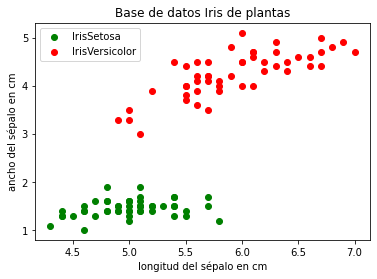

In [3]:
plt.scatter(X[y==0][:,0],X[y==0][:,2], color='green', label='IrisSetosa')
plt.scatter(X[y==1][:,0],X[y==1][:,2], color='red', label='IrisVersicolor')
plt.title('Base de datos Iris de plantas')
plt.xlabel('longitud del sépalo en cm')
plt.ylabel('ancho del sépalo en cm')
plt.legend()
plt.show()

En el gráfico anterior, hemos trazado la distribución de las dos clases. Para validar nuestros resultados, dividimos los datos en conjuntos de entrenamiento y validación (o prueba) de la siguiente manera:

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=17)

A continuación, inicializamos los pesos (*weights*) y sesgos (*bias*) para el perceptrón:

In [5]:
weights = np.random.normal(size=X_train.shape[1])
bias = 1

Antes de entrenar, necesitamos definir los hiperparámetros:

In [6]:
learning_rate = 0.1
n_epochs = 15

Ahora, podemos comenzar a entrenar nuestro perceptrón con un bucle for:

In [7]:
del_w = np.zeros(weights.shape)
hist_loss = []
hist_accuracy = []
for i in range(n_epochs):
    # Aplicamos una función de paso simple (escalón unitario), si la salida es> 0.5 predecimos 1, de lo contrario 0
    output = np.where((X_train.dot(weights)+bias)>0.5, 1, 0)
    # Calcular MSE
    error = np.mean((y_train-output)**2)
    # Actualizar pesos y bias
    weights-= learning_rate * np.dot((output-y_train), X_train)
    bias += learning_rate * np.sum(np.dot((output-y_train), X_train))
    # Calcular MSE
    loss = np.mean((output - y_train) ** 2)
    hist_loss.append(loss)
    # Determinar la exactitud de validación
    output_val = np.where(X_val.dot(weights)>0.5, 1, 0)
    accuracy = np.mean(np.where(y_val==output_val, 1, 0))
    hist_accuracy.append(accuracy)

Hemos guardado la pérdida en entrenamiento y la exactitud de validación para poder trazarlas:

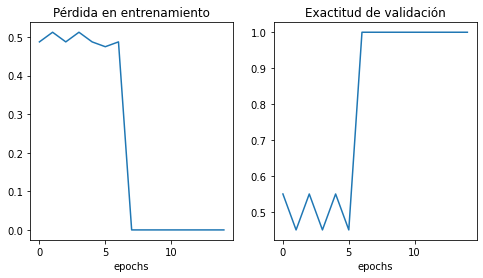

In [8]:
fig = plt.figure(figsize=(8, 4))
a = fig.add_subplot(1,2,1)
imgplot = plt.plot(hist_loss)
plt.xlabel('epochs')
a.set_title('Pérdida en entrenamiento')
a=fig.add_subplot(1,2,2)
imgplot = plt.plot(hist_accuracy)
plt.xlabel('epochs')
a.set_title('Exactitud de validación')
plt.show()

## Implementación de una red neuronal de capa única

Ahora podemos pasar a las **redes neuronales**. Comenzaremos implementando la forma más simple de una red neuronal: una red neuronal de capa única. La diferencia con un perceptrón es que los cálculos se realizan por múltiples unidades (neuronas), por lo tanto, una red. 

Como es de esperar, agregar más unidades aumentará la cantidad de problemas que se pueden resolver. Las unidades realizan sus cálculos por separado y se apilan en una capa; llamamos a esta capa la **capa oculta**. Por lo tanto, llamamos a las unidades apiladas en esta capa las **unidades ocultas** (o neuronas ocultas). Por ahora, solo consideraremos una sola capa oculta. La capa de salida funciona como un perceptrón. Esta vez, como entrada tenemos las unidades ocultas en la capa oculta en lugar de las variables de entrada:

<img src="capa_unica.png">

En nuestra implementación del perceptrón, hemos utilizado una función de escalón unitario para determinar la clase. En la siguiente implementación, utilizaremos una función de activación no lineal sigmoide para las unidades ocultas y para la función de salida. Al reemplazar la función de paso o escalón con una función de activación no lineal, la red también podrá descubrir patrones no lineales. En el paso hacia atrás, usamos la derivada del sigmoide para actualizar los pesos.

En el código siguiente, clasificaremos dos clases no separables linealmente con NumPy.

In [9]:
# Importar librerías y conjunto de datos:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Usaremos make_circles de scikit-learn
from sklearn.datasets import make_circles

Primero, necesitamos crear los datos de entrenamiento:

In [10]:
# Creamos un círculo interno y externo
X, y = make_circles(n_samples=400, factor=.3, noise=.05, random_state=2021)
outer = y == 0
inner = y == 1

# Normalizamos los datos para asegurarnos de que el centro de ambos círculos es (1,1):
X = X+1

Grafiquemos los datos para mostrar las dos clases:

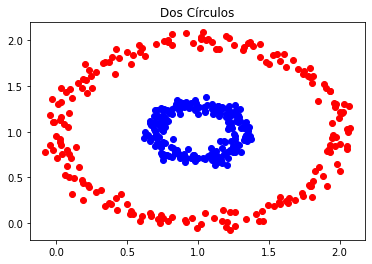

In [11]:
plt.title("Dos Círculos")
plt.plot(X[outer, 0], X[outer, 1], "ro")
plt.plot(X[inner, 0], X[inner, 1], "bo")
plt.show()

Para determinar el rendimiento de nuestro algoritmo, dividimos nuestros datos:

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2021)

Una función de activación lineal no funcionará en este caso, por lo que utilizaremos una función sigmoide:

In [13]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

A continuación, definimos los hiperparámetros:

In [14]:
n_hidden = 50 # número de unidades ocultas
n_epochs = 1000
learning_rate = 1

Inicializamos los pesos y otras variables:

In [15]:
weights_hidden = np.random.normal(0.0, size=(X_train.shape[1], n_hidden))
weights_output = np.random.normal(0.0, size=(n_hidden))
hist_loss = []
hist_accuracy = []

Ejecutamos la red neuronal de capa única e imprimimos las estadísticas:

In [16]:
for e in range(n_epochs):
    del_w_hidden = np.zeros(weights_hidden.shape)
    del_w_output = np.zeros(weights_output.shape)

    # Recorrer los datos de entrenamiento en lotes de 1
    for x_, y_ in zip(X_train, y_train):
        # Cálculos hacia adelante
        hidden_input = np.dot(x_, weights_hidden)
        hidden_output = sigmoid(hidden_input)
        output = sigmoid(np.dot(hidden_output, weights_output))
        # Cálculos hacia atrás
        error = y_ - output
        output_error = error * output * (1 - output)
        hidden_error = np.dot(output_error, weights_output) * hidden_output * (1 - hidden_output)
        del_w_output += output_error * hidden_output
        del_w_hidden += hidden_error * x_[:, None]
        
    # Actualizar pesos
    weights_hidden += learning_rate * del_w_hidden / X_train.shape[0]
    weights_output += learning_rate * del_w_output / X_train.shape[0]
    
    # Imprimir estadísticas (pérdida y exactitud de validación)
    if e % 100 == 0:
        hidden_output = sigmoid(np.dot(X_val, weights_hidden))
        out = sigmoid(np.dot(hidden_output, weights_output))
        loss = np.mean((out - y_val) ** 2)
    
        # La predicción final se basa en un umbral de 0.5
        predictions = out > 0.5
        accuracy = np.mean(predictions == y_val)
        print("Epoch: ", '{:>4}'.format(e), "; Pérdida de validación: ", '{:>6}'.format(loss.round(4)),
              "; Exactitud de validación: ", '{:>6}'.format(accuracy.round(4)))


Epoch:     0 ; Pérdida de validación:  0.4025 ; Exactitud de validación:  0.5125
Epoch:   100 ; Pérdida de validación:  0.1628 ; Exactitud de validación:     0.9
Epoch:   200 ; Pérdida de validación:  0.1323 ; Exactitud de validación:  0.9375
Epoch:   300 ; Pérdida de validación:  0.1108 ; Exactitud de validación:   0.975
Epoch:   400 ; Pérdida de validación:   0.095 ; Exactitud de validación:  0.9875
Epoch:   500 ; Pérdida de validación:  0.0831 ; Exactitud de validación:     1.0
Epoch:   600 ; Pérdida de validación:  0.0738 ; Exactitud de validación:     1.0
Epoch:   700 ; Pérdida de validación:  0.0663 ; Exactitud de validación:     1.0
Epoch:   800 ; Pérdida de validación:  0.0602 ; Exactitud de validación:     1.0
Epoch:   900 ; Pérdida de validación:   0.055 ; Exactitud de validación:     1.0


## Construyendo una red neuronal multicapa

Lo que hemos creado en código anterior es en realidad la forma más simple de una ANN: una red neuronal donde la información fluye solo en una dirección. Para nuestra próxima receta, ampliaremos el número de capas ocultas de una a varias capas. Agregar capas adicionales aumenta el poder de una red para aprender patrones no lineales complejos.

<img src="multicapa.png">

Al agregar una capa adicional, el número de conexiones (pesos), también llamados parámetros entrenables, aumenta exponencialmente. En la siguiente implemetación, crearemos una red con dos capas ocultas para predecir la **calidad de vino** con datos de vinos tintos descargado de https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/. Sin embargo, el archivo CSV ya se incluye en la carpeta de la práctica. 

Esta es una **tarea de regresión**, por lo que utilizaremos una activación lineal para la capa de salida. Para las capas ocultas, utilizamos las funciones de activación de **ReLU**. Esta receta utiliza el framework de **Keras** para implementar la FNN.

**Nota:** Se requiere [TensorFlow](https://www.tensorflow.org/install) y [Keras](https://keras.io/)

In [17]:
# Importar librerías
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# pip install tensorflow==2.1
# pip install Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

Cargar conjunto de datos:

In [18]:
data = pd.read_csv('winequality-red.csv', sep=';')
y = data['quality']
X = data.drop(['quality'], axis=1)

Separar datos para entrenamiento y prueba:

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

Imprimimos la calidad promedio y las primeras filas del conjunto de entrenamiento:

In [20]:
print('Calidad promedio del conjunto de entrenamiento: {:.4f}'.format(y_train.mean()))
X_train.head()

Calidad promedio del conjunto de entrenamiento: 5.6427


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
566,8.7,0.700,0.24,2.5,0.226,5.0,15.0,0.99910,3.32,0.60,9.0
1001,9.9,0.350,0.38,1.5,0.058,31.0,47.0,0.99676,3.26,0.82,10.6
224,8.4,0.635,0.36,2.0,0.089,15.0,55.0,0.99745,3.31,0.57,10.4
496,7.8,0.520,0.25,1.9,0.081,14.0,38.0,0.99840,3.43,0.65,9.0
722,7.6,0.420,0.08,2.7,0.084,15.0,48.0,0.99680,3.21,0.59,10.0


El siguiente paso importante es normalizar los datos de entrada:

In [21]:
scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

Ahora, construyamos nuestra red neuronal definiendo la arquitectura de red:

In [22]:
model = Sequential()
# Primera capa oculta con 200 unidades ocultas
model.add(Dense(200, input_dim=X_train.shape[1],
activation='relu'))
# Segunda capa oculta con 25 unidades ocultas
model.add(Dense(25, activation='relu'))
# Capa de salida
model.add(Dense(1, activation='linear'))
# Establecer optimizador
opt = Adam()
# Compilar modelo
model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])

Definamos la retrollamada para detener y guardar el mejor modelo:

In [23]:
callbacks = [
EarlyStopping(monitor='val_accuracy', patience=20, verbose=2),
ModelCheckpoint('checkpoints/multi_capa_mejor_modelo.h5',
monitor='val_accuracy', save_best_only=True, verbose=0)
]

Ejecutamos el modelo con un tamaño de lote de 64, 5000 épocas y una división de validación del 20%:

In [24]:
batch_size = 64
n_epochs = 1000
model.fit(X_train.values, y_train, batch_size=batch_size, epochs=n_epochs, validation_split=0.2, verbose=2,
callbacks=callbacks)

Epoch 1/1000
16/16 - 2s - loss: 28.6622 - accuracy: 0.0000e+00 - val_loss: 21.5580 - val_accuracy: 0.0000e+00
Epoch 2/1000
16/16 - 0s - loss: 14.9145 - accuracy: 0.0000e+00 - val_loss: 9.8429 - val_accuracy: 0.0000e+00
Epoch 3/1000
16/16 - 0s - loss: 6.0975 - accuracy: 0.0000e+00 - val_loss: 3.5804 - val_accuracy: 0.0000e+00
Epoch 4/1000
16/16 - 0s - loss: 3.1942 - accuracy: 0.0000e+00 - val_loss: 2.4708 - val_accuracy: 0.0000e+00
Epoch 5/1000
16/16 - 0s - loss: 2.4566 - accuracy: 0.0000e+00 - val_loss: 2.2716 - val_accuracy: 0.0000e+00
Epoch 6/1000
16/16 - 0s - loss: 2.0797 - accuracy: 0.0000e+00 - val_loss: 2.1654 - val_accuracy: 0.0000e+00
Epoch 7/1000
16/16 - 0s - loss: 1.8778 - accuracy: 0.0000e+00 - val_loss: 2.0172 - val_accuracy: 0.0000e+00
Epoch 8/1000
16/16 - 0s - loss: 1.7466 - accuracy: 0.0000e+00 - val_loss: 1.8815 - val_accuracy: 0.0000e+00
Epoch 9/1000
16/16 - 0s - loss: 1.6346 - accuracy: 0.0000e+00 - val_loss: 1.7423 - val_accuracy: 0.0000e+00
Epoch 10/1000
16/16 - 0s 

Ahora podemos imprimir el rendimiento en el conjunto de prueba después de cargar los pesos óptimos:

In [25]:
best_model = model
best_model.load_weights('checkpoints/multi_capa_mejor_modelo.h5')
best_model.compile(loss='mse', optimizer='adam' ,metrics=['accuracy'])
# Evaluar en conjunto de prueba
score_test = best_model.evaluate(X_test.values, y_test, verbose=0)
score_train = best_model.evaluate(X_train.values, y_train, verbose=0)
print('Exactitud en prueba: %.2f%%' % (score_test[1]*100))
print('Exactitud en entrenamiento: %.2f%%' % (score_train[1]*100))


Exactitud en prueba: 0.00%
Exactitud en entrenamiento: 0.00%


## Comparando funciones de activación

Si solo utilizamos funciones de activación lineal, una red neuronal representaría una gran colección de combinaciones lineales. Sin embargo, el poder de las redes neuronales radica en su capacidad para modelar comportamientos no lineales complejos. Introdujimos brevemente las funciones de activación **no lineal sigmoide y ReLU** en las implementaciones anteriores, y hay muchas funciones de activación no lineales más populares, como **ELU**, **Leaky ReLU**, **TanH** y **Maxout**. 

No existe una regla general sobre qué activación funciona mejor para las unidades ocultas. Deep Learning es un campo en investigacion y la mayoría de los resultados se obtienen por prueba y error.

En la siguiente implementación, compararemos la diferencia en los resultados entre una función de activación sigmoide y ReLU al clasificar los dígitos escritos a mano con una FNN profunda. El conjunto de datos se extrae desde Keras y corresponde a la base de datos MNIST (*Modified National Institute of Standards and Technology database*) de dígitos escritos a mano, accesible también en: http://yann.lecun.com/exdb/mnist/

In [26]:
# Importar librerías y conjunto de datos:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from keras.callbacks import Callback

from keras.datasets import mnist

Cargar el conjunto de datos MNIST:

In [27]:
(X_train, y_train), (X_val, y_val) = mnist.load_data()

11493376/11490434 [==============================] - 4s 0us/step


Mostrar un ejemplo de cada etiqueta e imprimir el conteo por etiqueta:

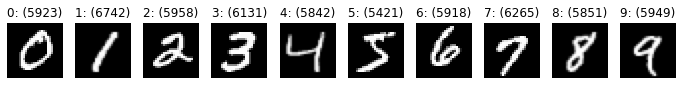

In [28]:
# Graficar la primera imagen de cada etiqueta
unique_labels = set(y_train)
plt.figure(figsize=(12, 12))
i = 1
for label in unique_labels:
    image = X_train[y_train.tolist().index(label)]
    plt.subplot(10, 10, i)
    plt.axis('off')
    plt.title("{0}: ({1})".format(label,
    y_train.tolist().count(label)))
    i += 1
    _ = plt.imshow(image, cmap='gray')
plt.show()

Preprocesar los datos:

In [29]:
# Normalizar datos
X_train = X_train.astype('float32')/255.
X_val = X_val.astype('float32')/255.

y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
# Acoplar datos: tratamos la imagen como una matriz secuencial de valores
X_train = np.reshape(X_train, (60000, 784))
X_val = np.reshape(X_val, (10000, 784))

Definir el modelo con la función de activación **sigmoide**:

In [30]:
model_sigmoid = Sequential()
model_sigmoid.add(Dense(700, input_dim=784, activation='sigmoid'))
model_sigmoid.add(Dense(700, activation='sigmoid'))
model_sigmoid.add(Dense(700, activation='sigmoid'))
model_sigmoid.add(Dense(700, activation='sigmoid'))
model_sigmoid.add(Dense(700, activation='sigmoid'))
model_sigmoid.add(Dense(350, activation='sigmoid'))
model_sigmoid.add(Dense(100, activation='sigmoid'))
model_sigmoid.add(Dense(10, activation='softmax'))

# Compilar modelo con SGD
model_sigmoid.compile(loss='categorical_crossentropy',
optimizer='sgd', metrics=['accuracy'])

Definir el modelo con la función de activación **ReLU**:

In [31]:
model_relu = Sequential()
model_relu.add(Dense(700, input_dim=784, activation='relu'))
model_relu.add(Dense(700, activation='relu'))
model_relu.add(Dense(700, activation='relu'))
model_relu.add(Dense(700, activation='relu'))
model_relu.add(Dense(700, activation='relu'))
model_relu.add(Dense(350, activation='relu'))
model_relu.add(Dense(100, activation='relu'))
model_relu.add(Dense(10, activation='softmax'))

# Compilar modelo con SGD
model_relu.compile(loss='categorical_crossentropy',
optimizer='sgd', metrics=['accuracy'])

Crear una función de retrollamada para almacenar los valores de pérdida por lote:

In [32]:
class history_loss(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)

Ejecutar modelos:

In [33]:
n_epochs = 10
batch_size = 256
validation_split = 0.2

history_sigmoid = history_loss()
model_sigmoid.fit(X_train, y_train,
                  epochs=n_epochs, batch_size=batch_size,
                  callbacks=[history_sigmoid], validation_split=validation_split, verbose=2)

history_relu = history_loss()
model_relu.fit(X_train, y_train,
               epochs=n_epochs, batch_size=batch_size, 
               callbacks=[history_relu], validation_split=validation_split, verbose=2)

Epoch 1/10
188/188 - 10s - loss: 2.3179 - accuracy: 0.1137 - val_loss: 2.3024 - val_accuracy: 0.1060
Epoch 2/10
188/188 - 10s - loss: 2.3014 - accuracy: 0.1140 - val_loss: 2.3025 - val_accuracy: 0.1060
Epoch 3/10
188/188 - 10s - loss: 2.3014 - accuracy: 0.1137 - val_loss: 2.3021 - val_accuracy: 0.1060
Epoch 4/10
188/188 - 10s - loss: 2.3013 - accuracy: 0.1136 - val_loss: 2.3024 - val_accuracy: 0.1060
Epoch 5/10
188/188 - 9s - loss: 2.3013 - accuracy: 0.1140 - val_loss: 2.3024 - val_accuracy: 0.1060
Epoch 6/10
188/188 - 9s - loss: 2.3013 - accuracy: 0.1140 - val_loss: 2.3025 - val_accuracy: 0.1060
Epoch 7/10
188/188 - 10s - loss: 2.3014 - accuracy: 0.1136 - val_loss: 2.3029 - val_accuracy: 0.1060
Epoch 8/10
188/188 - 10s - loss: 2.3014 - accuracy: 0.1140 - val_loss: 2.3024 - val_accuracy: 0.1060
Epoch 9/10
188/188 - 10s - loss: 2.3014 - accuracy: 0.1140 - val_loss: 2.3021 - val_accuracy: 0.1060
Epoch 10/10
188/188 - 9s - loss: 2.3013 - accuracy: 0.1140 - val_loss: 2.3026 - val_accuracy:

Graficar pérdidas:

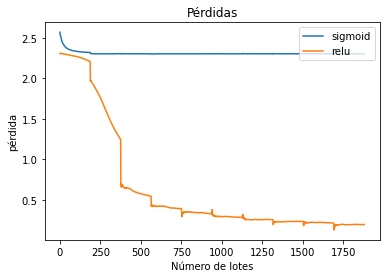

In [34]:
plt.plot(np.arange(len(history_sigmoid.losses)), history_sigmoid.losses, label='sigmoid')
plt.plot(np.arange(len(history_relu.losses)), history_relu.losses, label='relu')
plt.title('Pérdidas')
plt.xlabel('Número de lotes')
plt.ylabel('pérdida')
plt.legend(loc=1)
plt.show()

Extraer los pesos máximos de cada modelo por capa:

In [35]:
w_sigmoid = []
w_relu = []
for i in range(len(model_sigmoid.layers)):
    w_sigmoid.append(max(model_sigmoid.layers[i].get_weights()[1]))
    w_relu.append(max(model_relu.layers[i].get_weights()[1]))

Graficar los pesos de ambos modelos:

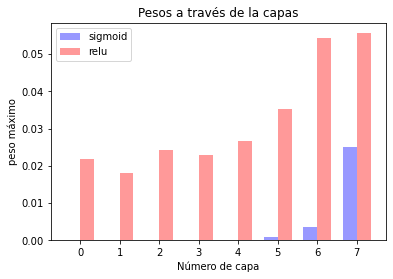

In [36]:
fig, ax = plt.subplots()

index = np.arange(len(model_sigmoid.layers))
bar_width = 0.35

plt.bar(index, w_sigmoid, bar_width, label='sigmoid',
color='b', alpha=0.4)
plt.bar(index + bar_width, w_relu, bar_width, label='relu',
color='r', alpha=0.4)
plt.title('Pesos a través de la capas')
plt.xlabel('Número de capa')
plt.ylabel('peso máximo')
plt.legend(loc=0)

plt.xticks(index + bar_width / 2, np.arange(8))
plt.show()

Con las redes neuronales convolucionales, revisaremos cómo obtener más del 99% de exactitud en el conjunto de datos MNIST.